# Initial Set Up
1.) Suppress unnecessary warnings

In [63]:
import warnings
warnings.filterwarnings("ignore")

2.) Installations: 

In [ ]:
pip install pyldavis==3.3.1
pip install spacy
!python3 -m spacy download 'en_core_web_sm'

# Preprocessing 

### 1.) Import Packages

In [50]:
import pandas as pd
import re
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim_models
import gensim
from gensim import corpora, models, similarities

import matplotlib.pyplot as plt 
import spacy



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/senaitdafa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.) Import data

In [53]:
text_df = pd.read_csv("UpennBox_SL_2020_content_extracted.csv")


In [54]:
text_df.shape

(6000, 4)

### 3.) remove rows with null content

In [10]:
text_df.dropna(subset = ['content'], inplace = True)

In [11]:
#tests if any null values are found in the content area column
text_df[text_df['content'].isnull() == True]

,gkgrecordid,date,documentidentifier,content


no rows are found, so all null content areas have been removed

### 4.) Create "bag-of-words"

In [12]:
text = text_df.content.values.tolist()

# Remove Emails
text = [re.sub('\S*@\S*\s?', '', sent) for sent in text]

# Remove new line characters
text = [re.sub('\s+', ' ', sent) for sent in text]

# Remove distracting single quotes
text = [re.sub("\'", "", sent) for sent in text]

### 5.) Prepare stopwords

In [13]:
stop_words = stopwords.words('english')

### 6.) Tokenize words/ clean text (remove punctuation

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

word_bag  = list(sent_to_words(text))

print(word_bag[:1])

[['be', 'the', 'first', 'to', 'read', 'breaking', 'stories']]


### 7.) Build Bigram/Trigram Models

In [15]:
bigram = gensim.models.Phrases(word_bag, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[word_bag], threshold=100)  

#variable creation
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


### 8.) Final application functions of stopwords, bigrams, lemmatization 

In [16]:
##functions are adpated from machinelearniningplus.com

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### 9.) Function call

In [17]:
# Remove Stop Words
stops = remove_stopwords(word_bag)

# Form Bigrams
word_bigrams = make_bigrams(stops)

# Initialize spacy 
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(word_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['first', 'read', 'break', 'story']]


### 10.) Dictionary/Corpus Creation

In [18]:
id_dict = corpora.Dictionary(data_lemmatized)

# Corpus
texts = data_lemmatized

# TDIF
corpus = [id_dict.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [19]:
#Better view from machinelearning.com
# Human readable format of corpus (term-frequency)
[[(id_dict[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('break', 1), ('first', 1), ('read', 1), ('story', 1)]]

### LDA Topic Model Creation

In [20]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id_dict,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
for x in lda_model.print_topics(-1):
    print(x)


(0, '0.020*"country" + 0.015*"government" + 0.014*"state" + 0.009*"member" + 0.009*"international" + 0.008*"also" + 0.007*"security" + 0.007*"report" + 0.007*"year" + 0.006*"conflict"')
(1, '0.060*"woman" + 0.042*"child" + 0.017*"girl" + 0.017*"mental" + 0.015*"access" + 0.015*"care" + 0.013*"country" + 0.011*"family" + 0.011*"violence" + 0.011*"risk"')
(2, '0.063*"food" + 0.036*"human" + 0.036*"tourism" + 0.029*"scientist" + 0.025*"animal" + 0.024*"population" + 0.022*"diamond" + 0.018*"farmer" + 0.016*"people" + 0.016*"launch"')
(3, '0.032*"court" + 0.024*"law" + 0.020*"human_right" + 0.020*"legal" + 0.019*"police" + 0.019*"run" + 0.016*"charge" + 0.016*"give" + 0.015*"arrest" + 0.014*"justice"')
(4, '0.153*"death" + 0.141*"case" + 0.133*"total" + 0.035*"new" + 0.033*"record" + 0.031*"region" + 0.029*"surveillance" + 0.028*"number" + 0.020*"report" + 0.016*"register"')
(5, '0.016*"year" + 0.013*"rate" + 0.013*"freetown" + 0.013*"time" + 0.012*"say" + 0.011*"city" + 0.011*"town" + 0.0

In [22]:
doc_lda = lda_model[corpus]


In [23]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint


import pickle
import re 
import pyLDAvis
import pyLDAvis.gensim_models



In [24]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


Coherence Score:  0.4312053790214364


In [25]:
pyLDAvis.enable_notebook()
lda_visual = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary = lda_model.id2word)
lda_visual

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.170227  0.036988       1        1  27.821740
0     -0.170902 -0.018844       2        1  12.343617
14    -0.198629  0.118323       3        1  10.155922
8     -0.170093  0.179674       4        1   7.496797
11    -0.111653 -0.131080       5        1   6.868598
16    -0.125260 -0.142341       6        1   6.586123
18    -0.138134 -0.105831       7        1   6.092155
17    -0.127673  0.056629       8        1   5.848998
7     -0.116157 -0.097954       9        1   3.410049
1     -0.083703 -0.094171      10        1   3.077521
5     -0.054919  0.014633      11        1   2.521244
15     0.155654 -0.043188      12        1   1.522803
9     -0.040832  0.228595      13        1   1.401743
12     0.082138 -0.177011      14        1   1.176366
3      0.176204  0.009164      15        1   1.155975
2      0.157150 -0.013252      16        1   0.806794
4      0.183429  0.234020      17        1   0.793196
13     0.180463  0.022003      18        1   0.537574
19     0.251467 -0.107653      19        1   0.381913
10     0.321677  0.031294      20        1   0.000870, topic_info=         Term          Freq         Total Category  logprob  loglift
163     death  11861.000000  11861.000000  Default  30.0000  30.0000
353      case  10777.000000  10777.000000  Default  29.0000  29.0000
123       say  38125.000000  38125.000000  Default  28.0000  28.0000
1438      die  34075.000000  34075.000000  Default  27.0000  27.0000
476    health  19798.000000  19798.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
25    convert      0.000532     48.295386  Topic20 -10.4364   0.2355
26       copy      0.000532     67.463835  Topic20 -10.4364  -0.0988
27          d      0.000532     50.917200  Topic20 -10.4364   0.1826
28        dad      0.000532    493.062183  Topic20 -10.4364  -2.0878
29    dancing      0.000532     25.534092  Topic20 -10.4364   0.8728

[1333 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4480      2  0.094191     abuse
4480     10  0.595116     abuse
4480     15  0.306121     abuse
304       5  0.098517    access
304       8  0.161870    access
...     ...       ...       ...
2763      3  0.994989      zika
3141      8  0.202210  zimbabwe
3141     13  0.794896  zimbabwe
3685     13  0.995364      zone
4450      7  0.994289      zoom

[3043 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 15, 9, 12, 17, 19, 18, 8, 2, 6, 16, 10, 13, 4, 3, 5, 14, 20, 11])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4f0fda59-c6a8-4e8e-8948-140616c5cf47' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [27]:
mallet_path = 'mallet/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id_dict)

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id_dict, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4756024816763338


coherence score increased with mallet LDA algorithm

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id_dict)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
model_list, coherence_values = compute_coherence_values(dictionary=id_dict, corpus=corpus, texts=texts, start=2, limit=20, step=1)

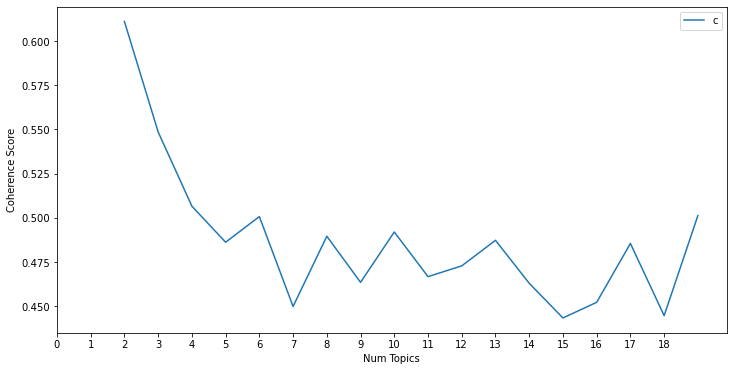

In [42]:
import numpy as np
limit=20; start=2; step=1;
x = range(start, limit, step)
fig = plt.subplots(figsize=(12, 6))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc='best')
plt.xticks(np.arange(0,19,1))

plt.show()

In [43]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.611
Num Topics = 3  has Coherence Value of 0.5486
Num Topics = 4  has Coherence Value of 0.5066
Num Topics = 5  has Coherence Value of 0.4862
Num Topics = 6  has Coherence Value of 0.5007
Num Topics = 7  has Coherence Value of 0.4499
Num Topics = 8  has Coherence Value of 0.4896
Num Topics = 9  has Coherence Value of 0.4635
Num Topics = 10  has Coherence Value of 0.492
Num Topics = 11  has Coherence Value of 0.4667
Num Topics = 12  has Coherence Value of 0.4728
Num Topics = 13  has Coherence Value of 0.4873
Num Topics = 14  has Coherence Value of 0.463
Num Topics = 15  has Coherence Value of 0.4434
Num Topics = 16  has Coherence Value of 0.4522
Num Topics = 17  has Coherence Value of 0.4855
Num Topics = 18  has Coherence Value of 0.4447
Num Topics = 19  has Coherence Value of 0.5013


The best fit model is the model with the highest coherence schore, however, considering the size and number of documents in the set, I am eliminating the models that have less than 5 topics. I've narrowed down the best model to 3 options: 19, 10, and 6 topics.


In [61]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    articles = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


model_10_keywords = format_topics_sentences(ldamodel=model_list[8], corpus = corpus, texts = texts)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.1866,"make, time, people, call, year, play, part, gi...","[first, read, break, story]"
1,1,4,0.4544,"make, time, people, call, year, play, part, gi...","[convert, vintage, reel, reel, recording, fair..."
2,2,0,0.1998,"die, work, year, hospital, care, nurse, covid,...","[sad, hear, death, bear, early, education, spe..."
3,3,5,0.3258,"country, health, include, government, support,...","[mission, conclude, weeklong, induction, train..."
4,4,2,0.4949,"country, government, development, service, glo...","[social_distancing, strategy, use, effective, ..."
...,...,...,...,...,...
5422,5422,4,0.2171,"make, time, people, call, year, play, part, gi...","[conakry, guinea, inter, guinean, incident, oc..."
5423,5423,3,0.4039,"case, people, virus, country, health, coronavi...","[genetic, code, coronavirus, cause, covid, cha..."
5424,5424,4,0.4689,"make, time, people, call, year, play, part, gi...","[board, space, shuttle, endeavour, begin, day,..."
5425,5425,1,0.3891,"school, woman, child, education, student, heal...","[annual, conference, united_methodist, church,..."


In [114]:
# Format
df_dominant_topic = model_10_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


df_dominant_topic.groupby('Dominant_Topic')['Document_No'].count()

Dominant_Topic
0     842
1     737
2     243
3     275
4     561
5     477
6     225
7     501
8     377
9    1189
Name: Document_No, dtype: int64

In [131]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topic.groupby('Dominant_Topic')['Document_No'].count()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4).to_frame()
topic_counts =topic_counts.to_frame()

# Topic Number and Keywords frame
topic_num_keywords = df_dominant_topic[['Dominant_Topic', 'Keywords']].drop_duplicates()

# Concatenate Column wise
df_dominant_topics = pd.merge(topic_num_keywords, topic_counts, on = 'Dominant_Topic')

# Change Column names

# Show
df_dominant_topics = df_dominant_topics.merge(topic_contribution, on  = 'Dominant_Topic')
df_dominant_topics

,Dominant_Topic,Keywords,Document_No_x,Document_No_y
0,9,"page, find, access, website, court, press, pol...",1189,0.2191
1,0,"people, time, make, woman, year, call, day, pl...",842,0.1552
2,2,"die, work, year, hospital, care, nurse, covid,...",243,0.0448
3,4,"government, state, country, international, afr...",561,0.1034
4,8,"woman, health, people, country, study, disease...",377,0.0695
5,5,"health, covid, support, country, include, resp...",477,0.0879
6,1,"case, country, people, virus, coronavirus, hea...",737,0.1358
7,6,"school, child, education, student, girl, peopl...",225,0.0415
8,7,"company, business, project, market, food, year...",501,0.0923
9,3,"country, travel, include, due, announce, day, ...",275,0.0507
